In [81]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from datetime import datetime, timedelta

### Download files and print them

In [2]:
# Specify the file paths
activity_file = 'vaud_activities.csv.gz'
population_file = 'vaud_population.csv.gz'
trip_file = 'vaud_trips.csv.gz'

# Read the gzipped CSV files
def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

# Read the dataframes
activity_df = read_gzipped_csv(activity_file)
population_df = read_gzipped_csv(population_file)
trip_df = read_gzipped_csv(trip_file)

### Preprocessing
#### How to filters the data : 
- decide a locality to study
- filters habitants of this locality
- [1st method] keep all facilities where an individual of the locality went once
- [2nd method] get the max coordinates over the whole filter population (maybe add a term to each coordonates to not exclude these people to the limits of the facilities)
- exclude facilities outside this area
- then I have the population and the localities of this locality

#### How to keep only relevant schedules : 
- exclude the whole schedule where at least one time is not in above 23:59:59 (more complex : change this schedule to be at home at midnight or start at home) 
- exclude the whole schedule where a facility is not in the list of facilities (devient inutile avec la 1ere methode : j'aurais tous les schedules des habitants et j'inclus automatiquement leurs facilities)

Work only on people (represanted by their id) where I have a whole correct schedules for them.

Tout faire sous forme de fonctions comme ca je peux changer de lieux d'etude si j'ai envie

### Formating
Enfin formater les donnees pour les utiliser dans le script C (?)

In [102]:
def valid_time(time_str):
    try:
        datetime.strptime(time_str, '%H:%M:%S')
        return True
    except ValueError:
        return False

In [78]:
print("Activity Data:")
print(activity_df.info())
print(activity_df.head())

Activity Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455006 entries, 0 to 4455005
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   id          int64  
 2   type        object 
 3   facility    object 
 4   link        object 
 5   x           float64
 6   y           float64
 7   start_time  object 
 8   end_time    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.9+ MB
None
   Unnamed: 0       id     type    facility    link          x          y  \
0      423464  1069770     home  home480932  399007  2569239.0  1190194.0   
1      423465  1069770     shop      168569  244909  2571696.0  1189601.0   
2      423466  1069770     home  home480932  399007  2569239.0  1190194.0   
3      423467  1069770  leisure      399230  399013  2569430.0  1189314.0   
4      423468  1069770     home  home480932  399007  2569239.0  1190194.0   
5      434919  1071953     home  home483115  136934  2551461.0  116

In [4]:
print("Population Data:")
print(population_df.info())
print(population_df.head())

Population Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825564 entries, 0 to 825563
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                825564 non-null  int64  
 1   age               825564 non-null  int64  
 2   bikeAvailability  825564 non-null  object 
 3   carAvail          825564 non-null  object 
 4   employed          825564 non-null  bool   
 5   hasLicense        825564 non-null  object 
 6   home_x            825564 non-null  float64
 7   home_y            825564 non-null  float64
 8   householdIncome   0 non-null       float64
 9   isCarPassenger    825564 non-null  bool   
 10  municipalityType  0 non-null       float64
 11  ptHasGA           825564 non-null  bool   
 12  ptHasHalbtax      825564 non-null  bool   
 13  ptHasStrecke      825564 non-null  bool   
 14  ptHasVerbund      825564 non-null  bool   
 15  sex               825564 non-null  object 
 16  spR

In [5]:
print("Trip Data:")
print(trip_df.info())
print(trip_df.head())

Trip Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3629442 entries, 0 to 3629441
Data columns (total 12 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   id                int64 
 2   mode              object
 3   dep_time          object
 4   trav_time         object
 5   start_link        object
 6   end_link          object
 7   transitRouteId    object
 8   boardingTime      object
 9   transitLineId     object
 10  accessFacilityId  object
 11  egressFacilityId  object
dtypes: int64(2), object(10)
memory usage: 332.3+ MB
None
   Unnamed: 0       id  mode  dep_time trav_time start_link end_link  \
0      345939  1069770  walk  09:23:32  00:45:38     399007   244909   
1      345940  1069770  walk  10:09:10  00:45:38     244909   399007   
2      345941  1069770  walk  10:54:48  00:16:15     399007   399013   
3      345942  1069770  walk  11:11:03  00:16:15     399013   399007   
4      354968  1071953   car  15:24:50

### Analyses the files

##### 1) Activities

In [6]:
activity_df.groupby('type')['facility'].count().head(10)

type
education          138568
home              1906623
leisure            419003
other              235921
pt interaction          0
shop               263958
work               444575
Name: facility, dtype: int64

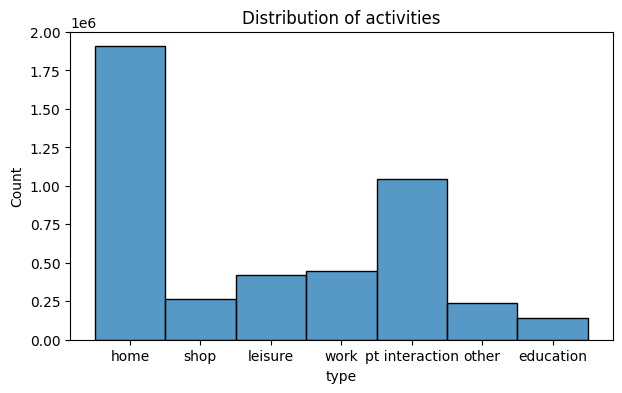

In [7]:
plt.figure(figsize=(7,4))
sns.histplot(activity_df['type'])
plt.title('Distribution of activities')
plt.show()

In [8]:
# a revoir pour la methode 1
def count_facilities_in_local(activity_df, local, population_df): 

    local_df = population_df[population_df['local'] == local]
    min_x, max_x = local_df['home_x'].min(), local_df['home_x'].max()
    min_y, max_y = local_df['home_y'].min(), local_df['home_y'].max()
    filtered_df = activity_df[(activity_df['x'] >= min_x) & (activity_df['x'] <= max_x) &
                              (activity_df['y'] >= min_y) & (activity_df['y'] <= max_y)]
    
    count_df = filtered_df.groupby('type')['facility'].count().reset_index()
    count_df.columns = ['Facility Type', 'Count']
    
    return count_df

In [9]:
localities = population_df.groupby(['local']).count()['id'].sort_values(ascending=False).head(2).index
for local in localities:
    count_df = count_facilities_in_local(activity_df, local, population_df)
    print(f"\nHere's the count of facilities by types in {local} :")
    print(count_df)
# on remarque qu'a chaque fois le nb de home est 2x superieur au nb d'habitants
# pt interaction = public transport interaction ?


Here's the count of facilities by types in Lausanne :
    Facility Type   Count
0       education   34085
1            home  433579
2         leisure   78156
3           other   40320
4  pt interaction       0
5            shop   56145
6            work  132032

Here's the count of facilities by types in Cheseaux-Noréaz :
    Facility Type  Count
0       education   7127
1            home  79726
2         leisure  11850
3           other   6886
4  pt interaction      0
5            shop   9310
6            work  16011

Here's the count of facilities by types in Renens VD :
    Facility Type  Count
0       education   4470
1            home  79853
2         leisure  12637
3           other   6660
4  pt interaction      0
5            shop  10006
6            work  15735

Here's the count of facilities by types in Nyon :
    Facility Type  Count
0       education   6288
1            home  53234
2         leisure   8390
3           other   4608
4  pt interaction      0
5            shop 

##### 2) Population of Vaud

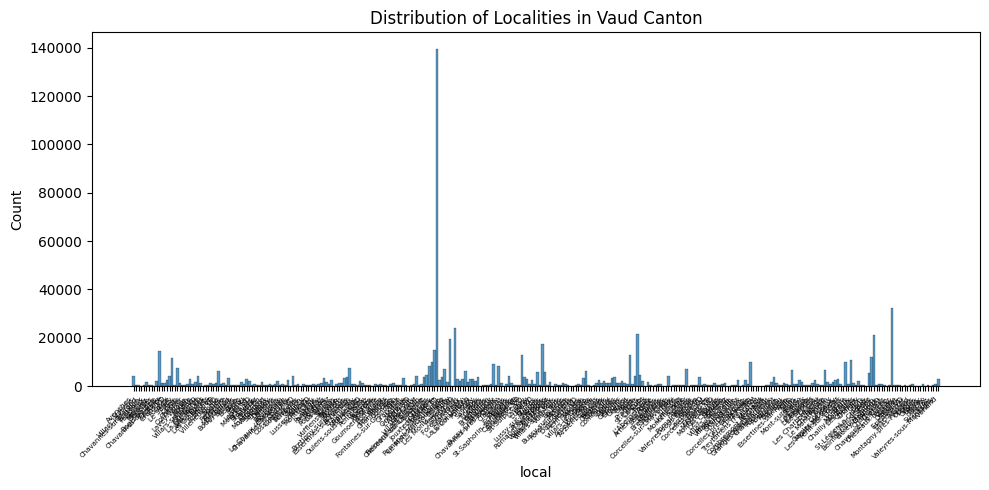

In [20]:
plt.figure(figsize=(10,5)) 
sns.histplot(population_df['local'])
plt.xticks(rotation=45, ha='right', fontsize=5)  
plt.title('Distribution of Localities in Vaud Canton')
plt.tight_layout()  
plt.show()


In [64]:
print("Count in local : \n")
print(population_df.groupby(['local']).count()['id'].sort_values(ascending=False).head(10))
print("\nCount in municipality :")
population_df.groupby(['municipality']).count()['id'].sort_values(ascending=False).head(10)
# 2e resultat est bizarre
# sinon c'est tjrs un peu over estimating mais coherent

Count in local : 

local
Lausanne              139392
Cheseaux-Noréaz        32372
Renens VD              24196
Nyon                   21597
Vevey                  21217
Pully                  19718
Morges                 17443
Jouxtens-Mézery        14887
Chavannes-des-Bois     14506
Gland                  13016
Name: id, dtype: int64

Count in municipality :


municipality
Lausanne              142041
Cheseaux-Noréaz        32372
Montreux               26761
Renens (VD)            24196
Nyon                   21597
Vevey                  21217
Pully                  19887
Morges                 17443
Jouxtens-Mézery        14887
Chavannes-des-Bois     14506
Name: id, dtype: int64

In [59]:
# Viewing # of unique values for each column
print("Unique Postcodes: ", population_df['postcode'].nunique())
print("Unique Locals: ", population_df['local'].nunique())
print("Unique Municipalities: ", population_df['municipality'].nunique())

# Quelle difference ? 
print(population_df[['postcode', 'local', 'municipality']].drop_duplicates().head())


Unique Postcodes:  321
Unique Locals:  314
Unique Municipalities:  251
    postcode                 local          municipality
0       1580              Avenches              Avenches
9       1085              Vulliens              Vulliens
14      1584      Villars-le-Grand        Vully-les-Lacs
79      1512  Chavannes-sur-Moudon  Chavannes-sur-Moudon
86      1612              Ecoteaux                  Oron


In [55]:
population_df['age'].mean().round()

42.0

In [80]:
palette = sns.color_palette("husl", n_colors=len(set(activity_df['type'])))
color_palette = dict(zip(set(activity_df['type']), palette))
color_palette['transport'] = 'grey'

In [87]:
def plot_schedule(activity_df, individual_id):
    # Filter the DataFrame for the specific id
    # ASSUMPTION : 'es activites sont deja chronologiques pour chaque individual id
    individual_schedule = activity_df[activity_df['id'] == individual_id]
    individual_schedule = individual_schedule.sort_index()
    
    segments = []
    colors = []
    fig, ax = plt.subplots(figsize=(10, 1))
    
    start_of_day = datetime.strptime('00:00:00', '%H:%M:%S')
    end_of_day = datetime.strptime('23:59:59', '%H:%M:%S')
    prev_end = start_of_day
    
    for _, facility in individual_schedule.iterrows():
        start_time = datetime.strptime(facility['start_time'], '%H:%M:%S') if pd.notna(facility['start_time']) else start_of_day
        end_time = datetime.strptime(facility['end_time'], '%H:%M:%S') if pd.notna(facility['end_time']) else end_of_day
        
        if prev_end < start_time:
            segments.append([(prev_end - start_of_day).total_seconds() / 3600, (start_time - prev_end).total_seconds() / 3600])
            colors.append(color_palette['transport'])
            ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
            
        segments.append([(start_time - start_of_day).total_seconds() / 3600, (end_time - start_time).total_seconds() / 3600])
        colors.append(color_palette[facility['type']])
        ax.broken_barh([segments[-1]], (0, 1), facecolors=colors[-1])
        
        prev_end = end_time


    legend_patches = [mpatches.Patch(color=color, label=activity) for activity, color in color_palette.items()]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlim(0, 24)
    ax.set_yticks([])
    ax.set_xticks(range(25))
    ax.set_xlabel('Time (hours)')
    plt.show()

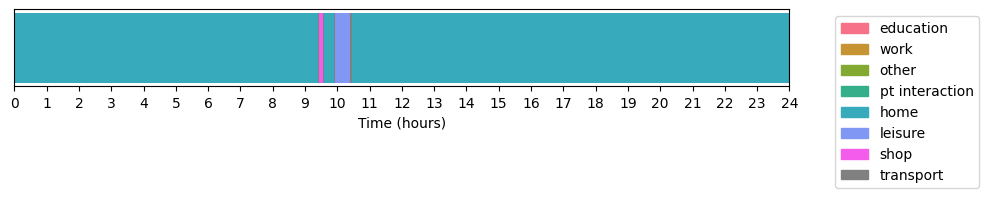

In [88]:
individual_id = 1069770 # 1071953     
plot_schedule(activity_df, individual_id)

In [117]:
def plot_start_time_distribution(activity_df, activity_type):

    activity_type_df = activity_df[activity_df['type'] == activity_type]
    activity_type_df = activity_type_df[activity_type_df['start_time'].apply(valid_time)] # should be done before teh function call !
    start_times = activity_type_df['start_time'].dropna()
    hours = start_times.apply(lambda x: datetime.strptime(x, '%H:%M:%S').hour + datetime.strptime(x, '%H:%M:%S').minute / 60)
    
    plt.figure(figsize=(10, 6))
    plt.hist(hours, bins=24, range=(0,24), edgecolor='black', alpha=0.7, color='dodgerblue', density=False)
    plt.title(f'Start Time Distribution of {activity_type} Activity')
    plt.xlabel('Time (hours)')
    plt.ylabel('Density')
    plt.xticks(range(25))
    plt.tight_layout()
    plt.show()

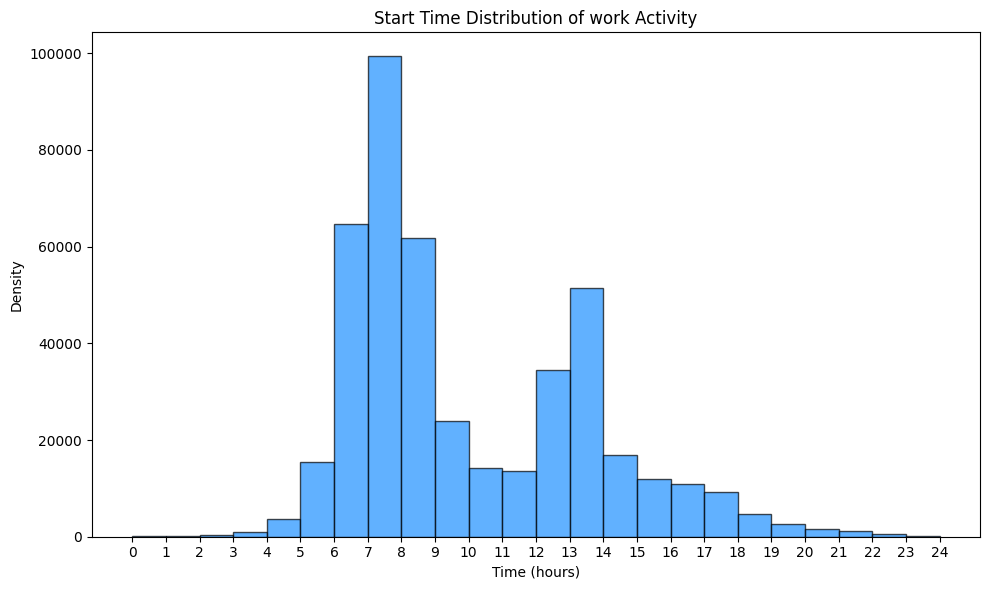

In [118]:
plot_start_time_distribution(activity_df, 'work')